In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load Model

In [6]:
import sys

sys.path.append("/home/ay/Coding2/0-Deepfake/2-Audio/experiments")
from phoneme_model import load_phoneme_model

In [7]:
network_name='wav2vec'
if network_name == 'wav2vec':
    # pretrained_path = "/home/ay/data/best-epoch=17-val-per=0.312388.ckpt"
    pretrained_path = "/home/ay/data/DATA/1-model_save/01-phoneme/phoneme_recongition/version_0/checkpoints/best-epoch=28-val-per=0.278449.ckpt"
    # pretrained_path="/home/ay/data/DATA/1-model_save/01-phoneme/phoneme_recongition/version_4/checkpoints/best-epoch=57-val-per=0.268208.ckpt"
    # pretrained_path="/home/ay/data/DATA/1-model_save/01-phoneme/phoneme_recongition/version_5/checkpoints/best-epoch=49-val-per=0.273750.ckpt"
    # pretrained_path = "/home/ay/data/best-epoch=43-val-per=0.449877.ckpt"
    # pretrained_path = "/home/ay/data/best-epoch=49-val-per=0.440167.ckpt"
    pretrained_path = "/home/ay/data/best-epoch=32-val-per=0.398863.ckpt"
else:
    pretrained_path = "/home/ay/data/phonemes/wavlm/best-epoch=19-val-per=0.489741.ckpt"
    

In [8]:
org_model = load_phoneme_model(network_name=network_name, pretrained_path=None, total_num_phonemes=687).cuda(1)
org_model =org_model.eval()

phoneme_model = load_phoneme_model(pretrained_path=pretrained_path, total_num_phonemes=687).cuda(1)
phoneme_model = phoneme_model.eval()

/home/ay/anaconda3/envs/torch/lib/python3.9/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of the model checkpoint at /usr/local/ay_data/0-model_weights/models--facebook--wav2vec2-base-960h were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that 

# Load dataset

In [9]:
import sys

sys.path.append("/home/ay/Coding2/0-Deepfake/2-Audio")

In [10]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Sampler, default_collate, random_split

try:
    from .data.tools import WaveDataset
except ImportError:
    from data.tools import WaveDataset

In [11]:
from ay2.datasets.audio import MLAAD_AudioDs

In [12]:
def load_MLAAD_subset(root_path: str = "/home/ay/data/0-原始数据集/MLADD", language: str = "en", n_audios=1000):
    ds = MLAAD_AudioDs(root_path=root_path)
    if isinstance(language, str):
        data = ds.data.query(f"language == {language}")
    else:
        data = ds.data.query(f"language in {language}")

    sampled_data = [data.query(f"label == {i}").sample(n_audios//2, random_state=42) for i in [0, 1]]
    sampled_data = pd.concat(sampled_data, ignore_index=True)
    
    _ds = WaveDataset(
        sampled_data,
        sample_rate=16000,
        normalize=True,
        transform=None,
        dtype="tensor",
    )
    print(f"read {len(_ds)} audios for the language {language} in {root_path}")
    return _ds

In [ ]:
# _ds = load_MLAAD_subset(language=["en", "es", "de"], n_audios=3000)
_ds = load_MLAAD_subset(language=["en"], n_audios=1000)

# Compute weights

In [13]:
from ay2.visualization.tsne import (
    add_rounded_rectangle_border_for_image,
    plot_tSNE_res,
    tSNE_cluster,
)
from utils import reduce_feat_by_phonemes

In [ ]:
predict_ids = torch.randint(0, 2, (10,))
unique_ids, inverse, counts = predict_ids.unique_consecutive(return_inverse=True, return_counts=True)
inverse, counts

In [ ]:
weight = counts[inverse]
weight / 10

In [14]:
def get_weights(logits):
    """

    Args:
        logits: shape of (L,)
    """

    predict_ids = torch.argmax(logits, dim=-1)
    unique_ids, inverse, counts = predict_ids.unique_consecutive(return_inverse=True, return_counts=True)
    consecutive_counts_per_frame = counts[inverse]  # (L,), the consecutive number of each frame

    weights_tensor = consecutive_counts_per_frame
    weights_tensor = weights_tensor / torch.sum(weights_tensor)
    return weights_tensor

In [15]:
def get_weighted_hidden_state(model, x, reduce_hidden_state=True, phoneme_detect_model=None):
    model_res = model.model.model(x, output_hidden_states=True)
    logits = model_res.logits[0]  # (T)
    if phoneme_detect_model is None:
        predict_ids = torch.argmax(logits, dim=-1)  # (T)
    else:
        _model_res = phoneme_detect_model.model.model(x, output_hidden_states=True)
        _logits = _model_res.logits[0]  # (T)
        predict_ids = torch.argmax(_logits, dim=-1)  # (T)
    
    unique_ids = predict_ids.unique_consecutive()
    hidden_state = model_res.hidden_states[-1][0]  # (T, C)

    if reduce_hidden_state:
        hidden_state, _, _ = reduce_feat_by_phonemes(
            hidden_states=hidden_state[None, ...],
            audio_lengths=torch.tensor([1]),
            phoneme_ids=predict_ids[None, ...],
        )
        _h = hidden_state.mean(0)
    else:
        _h = hidden_state.mean(0)

    # weights = get_weights(logits).to(x.device)
    # _h = torch.sum(hidden_state * weights[:, None], dim=0)
    # print(weights.shape, _h.shape)
    # _h = hidden_state.mean(0)
    return _h, unique_ids

In [16]:
def get_hidden_states_and_labels(model, _ds, reduce_hidden_state=True,phoneme_detect_model=None):
    hidden_states = []
    labels = []
    phoneme_ids = []
    for i in tqdm(range(len(_ds))):
        item = _ds[i]
        x = item["audio"].cuda(1)

        # if x.size(1) > 64000:
        # x = x[:, :64000]
        with torch.no_grad():
            hidden_state, _phoneme_ids = get_weighted_hidden_state(model, x, reduce_hidden_state=reduce_hidden_state,phoneme_detect_model=phoneme_detect_model)
        hidden_states.append(hidden_state)
        labels.append(item["label"])
        phoneme_ids.append(_phoneme_ids)

    hidden_states = torch.stack(hidden_states).detach().cpu()
    return hidden_states, labels, phoneme_ids

In [17]:
def get_subpart(_index, label):
    if labels[_index] == label:
        return True
    else:
        return False

# 分析phoneme id　

In [ ]:
_ds = load_MLAAD_subset(language=["en"], n_audios=1000)
hidden_states, labels, phoneme_ids = get_hidden_states_and_labels(model, _ds)

In [ ]:
real_ids = []
fake_ids = []
for i, label in enumerate(labels):
    if label == 1:
        real_ids += list(phoneme_ids[i].cpu().numpy())
    else:
        fake_ids += list(phoneme_ids[i].cpu().numpy())
print(len(real_ids), len(fake_ids))

In [ ]:
real_ids = [x for x in real_ids if x > 4]
fake_ids = [x for x in fake_ids if x > 4]
bins = len(set(real_ids + fake_ids))

_ = plt.hist(real_ids, bins=bins, color="red", alpha=0.9)
_ = plt.hist(fake_ids, bins=bins, color="#C1F320", alpha=0.5)

# Plot 

In [ ]:
language=['en']
_ds = load_MLAAD_subset(language=language, n_audios=1000)
hidden_states, labels, phoneme_ids = get_hidden_states_and_labels(phoneme_model, _ds, reduce_hidden_state=False)

result = tSNE_cluster(hidden_states)
plot_tSNE_res(
    result,
    point_labels=[1, 0],
    legend_labels=["Real", "Fake"],
    index_func=get_subpart,
    markers=["o", "^"],
    colors=["red", "blue"],
    save_path=None,
    add_lefttop_text=language[0].capitalize(),
)

read 3000 audios for the language ['uk'] in /home/ay/data/0-原始数据集/MLADD


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [02:48<00:00, 17.85it/s]


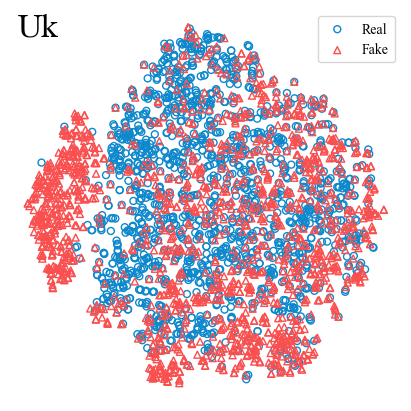

read 3000 audios for the language ['fr'] in /home/ay/data/0-原始数据集/MLADD


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [02:59<00:00, 16.72it/s]


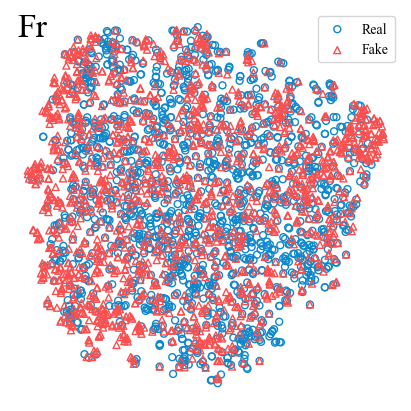

read 3000 audios for the language ['it'] in /home/ay/data/0-原始数据集/MLADD


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [02:19<00:00, 21.52it/s]


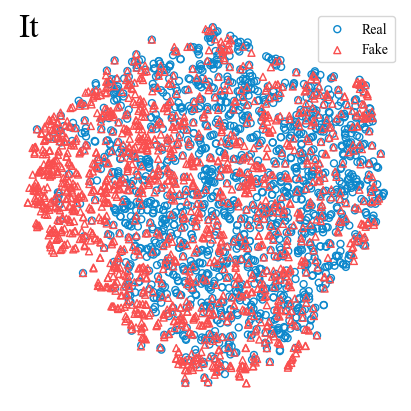

read 3000 audios for the language ['en'] in /home/ay/data/0-原始数据集/MLADD


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [02:33<00:00, 19.56it/s]


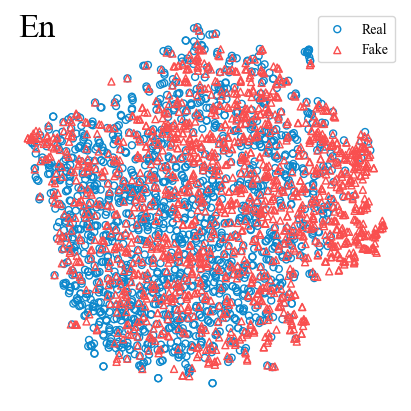

read 3000 audios for the language ['de'] in /home/ay/data/0-原始数据集/MLADD


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [02:48<00:00, 17.83it/s]


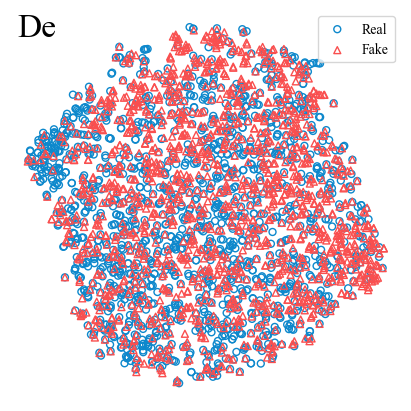

read 3000 audios for the language ['es'] in /home/ay/data/0-原始数据集/MLADD


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [02:25<00:00, 20.66it/s]


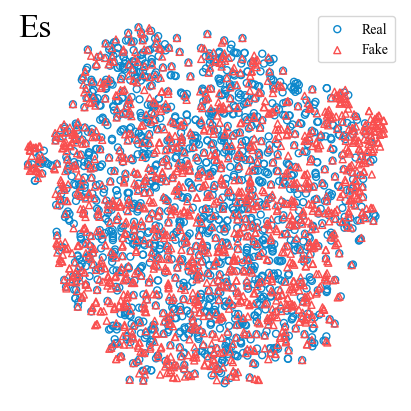

read 3000 audios for the language ['ru'] in /home/ay/data/0-原始数据集/MLADD


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [02:24<00:00, 20.77it/s]


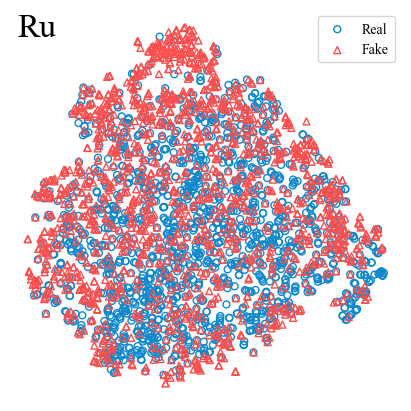

read 3000 audios for the language ['pl'] in /home/ay/data/0-原始数据集/MLADD


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [02:38<00:00, 18.88it/s]


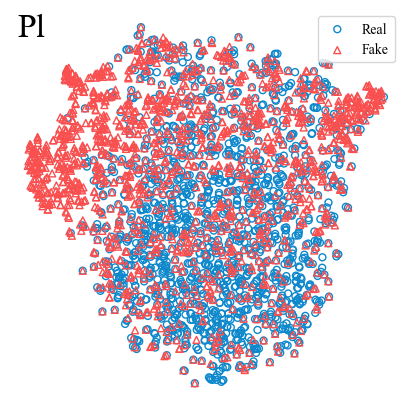

In [20]:
# v0, e28
model_type = 'org'
model = org_model if model_type == 'org' else phoneme_model
reduce_hidden_state = False
for N in [3000]:
    for language in ["uk", "fr", "it", "en", "de", "es", "ru", "pl"]:
        _ds = load_MLAAD_subset(language=[language], n_audios=N)
        hidden_states, labels, phoneme_ids = get_hidden_states_and_labels(model, _ds, reduce_hidden_state=reduce_hidden_state)

        result = tSNE_cluster(hidden_states)
        save_path = f"./imgs/{network_name}2/{model_type}-reduce-{reduce_hidden_state}/{N}/"
        if not os.path.exists(save_path): os.makedirs(save_path)
        save_name = os.path.join(save_path, f'{language}.png')
        plot_tSNE_res(
            result,
            point_labels=[1, 0],
            legend_labels=["Real", "Fake"],
            index_func=get_subpart,
            markers=["o", "^"],
            colors=["#0d88cc", "#f94f4f"],
            # colors=["red", "blue"],
            save_path=save_name,
            add_lefttop_text=language.capitalize(),
        )
        add_rounded_rectangle_border_for_image(save_name, corner_radius=60, border_width=10)
# !zip -r imgs/imgs.zip imgs

In [ ]:
# v0, e28
model_type = 'phoneme'
model = org_model if model_type == 'org' else phoneme_model
reduce_hidden_state = True
for N in [3000]:
    for language in ["uk", "fr", "it", "en", "de", "es", "ru", "pl"]:
        _ds = load_MLAAD_subset(language=[language], n_audios=N)
        hidden_states, labels, phoneme_ids = get_hidden_states_and_labels(model, _ds, reduce_hidden_state=reduce_hidden_state)

        result = tSNE_cluster(hidden_states)
        save_path = f"./imgs/{network_name}2/{model_type}-reduce-{reduce_hidden_state}/{N}/"
        if not os.path.exists(save_path): os.makedirs(save_path)
        save_name = os.path.join(save_path, f'{language}.png')
        plot_tSNE_res(
            result,
            point_labels=[1, 0],
            legend_labels=["Real", "Fake"],
            index_func=get_subpart,
            markers=["o", "^"],
,
            colors=["#0d88cc", "#f94f4f"],
            add_lefttop_text=language.capitalize(),
        )
        add_rounded_rectangle_border_for_image(save_name, corner_radius=60, border_width=10)
!zip -r imgs/imgs.zip imgs

In [ ]:
# v0, e28
model_type = 'phoneme'
model = org_model if model_type == 'org' else phoneme_model
reduce_hidden_state = False
for N in [3000]:
    for language in ["uk", "fr", "it", "en", "de", "es", "ru", "pl"]:
        _ds = load_MLAAD_subset(language=[language], n_audios=N)
        hidden_states, labels, phoneme_ids = get_hidden_states_and_labels(model, _ds, reduce_hidden_state=reduce_hidden_state)

        result = tSNE_cluster(hidden_states)
        save_path = f"./imgs/{network_name}2/{model_type}-reduce-{reduce_hidden_state}/{N}/"
        if not os.path.exists(save_path): os.makedirs(save_path)
        save_name = os.path.join(save_path, f'{language}.png')
        plot_tSNE_res(
            result,
            point_labels=[1, 0],
            legend_labels=["Real", "Fake"],
            index_func=get_subpart,
            markers=["o", "^"],
            result,
            save_path=save_name,
            add_lefttop_text=language.capitalize(),
        )
        add_rounded_rectangle_border_for_image(save_name, corner_radius=60, border_width=10)
!zip -r imgs/imgs.zip imgs

In [24]:
!zip -r imgs/imgs.zip imgs

  adding: imgs/ (stored 0%)
  adding: imgs/.ipynb_checkpoints/ (stored 0%)
  adding: imgs/wavlm/ (stored 0%)
  adding: imgs/wavlm/org-reduce-False/ (stored 0%)
  adding: imgs/wavlm/org-reduce-False/1000/ (stored 0%)
  adding: imgs/wavlm/org-reduce-False/1000/es.png (deflated 3%)
  adding: imgs/wavlm/org-reduce-False/1000/fr.png (deflated 3%)
  adding: imgs/wavlm/org-reduce-False/1000/it.png (deflated 3%)
  adding: imgs/wavlm/org-reduce-False/1000/en.png (deflated 4%)
  adding: imgs/wavlm/org-reduce-False/1000/uk.png (deflated 5%)
  adding: imgs/wavlm/org-reduce-False/1000/pl.png (deflated 3%)
  adding: imgs/wavlm/org-reduce-False/1000/ru.png (deflated 3%)
  adding: imgs/wavlm/org-reduce-False/1000/de.png (deflated 3%)
  adding: imgs/wavlm/org-reduce-False/3000/ (stored 0%)
  adding: imgs/wavlm/org-reduce-False/3000/es.png (deflated 3%)
  adding: imgs/wavlm/org-reduce-False/3000/fr.png (deflated 3%)
  adding: imgs/wavlm/org-reduce-False/3000/it.png (deflated 2%)
  adding: imgs/wavlm/org

read 3000 audios for the language ['uk'] in /home/ay/data/0-原始数据集/MLADD


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [04:10<00:00, 11.99it/s]


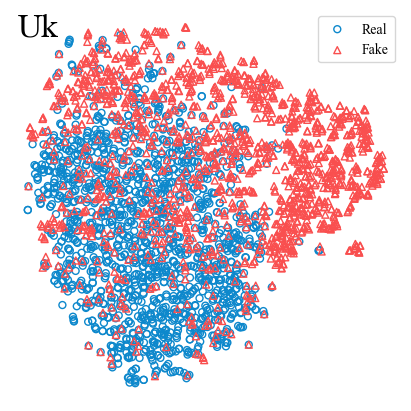

read 3000 audios for the language ['fr'] in /home/ay/data/0-原始数据集/MLADD


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [04:20<00:00, 11.53it/s]


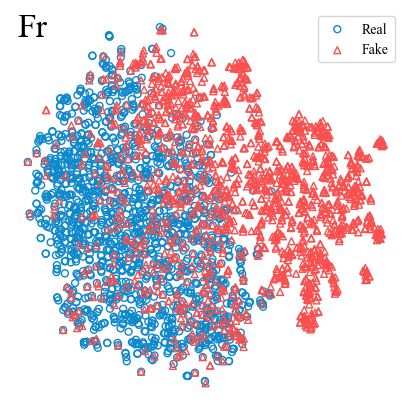

read 3000 audios for the language ['it'] in /home/ay/data/0-原始数据集/MLADD


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [03:28<00:00, 14.38it/s]


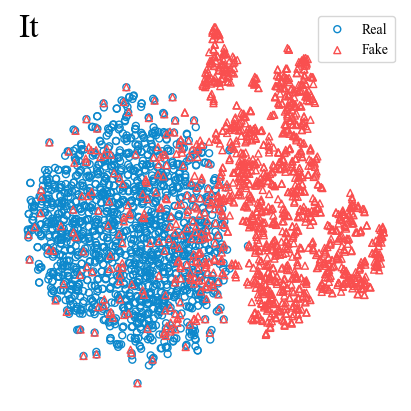

read 3000 audios for the language ['en'] in /home/ay/data/0-原始数据集/MLADD


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [03:31<00:00, 14.18it/s]


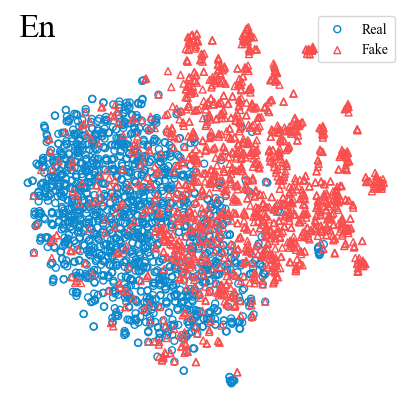

read 3000 audios for the language ['de'] in /home/ay/data/0-原始数据集/MLADD


  8%|███████████▏                                                                                                                         | 253/3000 [00:18<03:57, 11.58it/s]

In [ ]:
# v0, e28
model_type = 'org'
model = org_model if model_type == 'org' else phoneme_model
reduce_hidden_state = True
for N in [3000]:
    for language in ["uk", "fr", "it", "en", "de", "es", "ru", "pl"]:
        _ds = load_MLAAD_subset(language=[language], n_audios=N)
        hidden_states, labels, phoneme_ids = get_hidden_states_and_labels(model, _ds, reduce_hidden_state=reduce_hidden_state, phoneme_detect_model=phoneme_model)

        result = tSNE_cluster(hidden_states)
        save_path = f"./imgs/{network_name}2/{model_type}-reduce-{reduce_hidden_state}/{N}/"
        if not os.path.exists(save_path): os.makedirs(save_path)
        save_name = os.path.join(save_path, f'{language}.png')
        plot_tSNE_res(
            result,
            point_labels=[1, 0],
            legend_labels=["Real", "Fake"],
            index_func=get_subpart,
            markers=["o", "^"],
            colors=["#0d88cc", "#f94f4f"],
            # colors=["red", "blue"],
            save_path=save_name,
            add_lefttop_text=language.capitalize(),
        )
        add_rounded_rectangle_border_for_image(save_name, corner_radius=60, border_width=10)
# !zip -r imgs/imgs.zip imgs